# Apprendimento per rinforzo {#sec-rescorla-wagner}

**Prerequisiti**

Il presente tutorial trae ispirazione dall'articolo di [Wilson & Collins (2019)](https://elifesciences.org/articles/49547) e utilizza il codice fornito da [Rhoads, S. A. & Gan, L. (2022)](https://shawnrhoads.github.io/gu-psyc-347/index.html).

**Concetti e competenze chiave**

- Concetti di apprendimento associativo, agente, ambiente, azioni, ricompense, politica e valore Q.
- Concetti di esplorazione/sfruttamento.
- Regola softmax.
- Politica *greedy* e suoi limiti.
- Modello Rescorla-Wagner e sua implementazione in Stan.
- Limitazioni degli algoritmi RL.

**Preparazione del Notebook**

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from cmdstanpy import CmdStanModel

# Configuration
seed = sum(map(ord, "rescorla_wagner"))
rng = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"

## Introduzione {.unnumbered}

Nel @sec-change-across-time abbiamo introdotto l'approccio bayesiano per descrivere i processi dinamici. In questo capitolo, presenteremo un altro esempio di questo approccio implementando uno dei modelli psicologici dinamici più influenti: il modello di apprendimento di Rescorla-Wagner. Dopo una breve introduzione storica, esamineremo la definizione del modello, il significato dei suoi parametri e i metodi per stimarli dai dati osservati, con un focus particolare sull'uso del linguaggio di programmazione probabilistica Stan.

## Note Storiche

Negli anni '50, uno dei concetti fondamentali nell'intelligenza artificiale (AI) era quello dell'apprendimento per rinforzo, che sosteneva l'importanza di incoraggiare le azioni che avevano avuto successo in passato. Questo approccio ha portato allo sviluppo di algoritmi avanzati per il gioco. Nei decenni successivi, l'apprendimento per rinforzo ha visto un'evoluzione significativa, applicandosi con successo a giochi complessi come il Go e al controllo di sistemi robotici altamente sofisticati.

Un aspetto centrale dell'apprendimento per rinforzo è la capacità di bilanciare l'acquisizione di conoscenza sull'ambiente con l'azione all'interno di esso. Questo equilibrio rappresenta una sfida complessa, anche in situazioni in cui le azioni non comportano un cambiamento nell'ambiente stesso. Nel contesto del machine learning, il processo di esplorazione, ovvero compiere un'azione e osservarne l'effetto, è fondamentale per apprendere. Tuttavia, l'esplorazione comporta il rischio di non sfruttare un'azione che già si conosce come vantaggiosa. Esiste quindi un inevitabile compromesso tra l'esplorazione di nuove opzioni e lo sfruttamento di quelle già note.

Questo concetto di apprendimento basato sul bilanciamento tra esplorazione e sfruttamento trova un'interessante applicazione anche nel campo della psicologia, in particolare attraverso il modello di Rescorla-Wagner. Sviluppato negli anni '70 da Robert Rescorla e Allan Wagner, questo modello è ampiamente utilizzato per spiegare come animali e esseri umani apprendano le associazioni tra stimoli e conseguenze delle azioni [@rescorla1972theory]. Questo modello è alla base di molti approcci più recenti nell'apprendimento per rinforzo e nelle neuroscienze computazionali [@soto2023rescorla].

Il modello di Rescorla-Wagner si basa sull'idea che l'apprendimento avvenga in funzione della discrepanza tra ciò che un individuo si aspetta e ciò che effettivamente accade. In altre parole, l'apprendimento è guidato dall'errore di previsione: quando l'esito di una situazione differisce da ciò che ci si aspettava, le associazioni mentali tra gli eventi coinvolti vengono aggiornate. Il modello suggerisce che la forza dell'apprendimento dipende dall'intensità della sorpresa generata dall'esito osservato.

Per esempio, immagina di partecipare a un esperimento in cui, ogni volta che compi una specifica azione, si verifica un evento che ti sorprende. All'inizio, non ti aspetti che quell'evento segua l'azione, quindi apprendi rapidamente l'associazione tra l'azione e l'evento. Con il tempo, man mano che ti abitui a questa sequenza, l'apprendimento rallenta, perché diventi più bravo a prevedere l'esito e la sorpresa diminuisce.

Questo modello ha avuto un impatto significativo nello studio dell'apprendimento e continua a essere un punto di riferimento per comprendere i meccanismi attraverso i quali formiamo associazioni basate sulle nostre esperienze.

## Concetti Fondamentali

Per comprendere l'apprendimento associativo, è importante introdurre alcuni concetti chiave che sono comunemente utilizzati nella letteratura sull'apprendimento per rinforzo.

Nell'apprendimento per rinforzo, immaginiamo un "agente" che interagisce con un "ambiente", in modo simile a un giocatore che esplora un nuovo videogioco. L'agente esegue una serie di azioni per scoprire quali siano le migliori per ottenere la massima ricompensa. Questo processo si svolge in vari turni, durante i quali l'agente fa delle scelte e riceve feedback sotto forma di ricompense [@sutton2018reinforcement].

Ad ogni turno, l'agente seleziona un'azione tra quelle disponibili. In uno scenario semplice, potrebbe dover scegliere tra due opzioni, come decidere tra due porte in un gioco. Dopo aver fatto la sua scelta, l'agente riceve una ricompensa, che può essere positiva o negativa, in base al risultato dell'azione intrapresa. Per visualizzare questo concetto, possiamo immaginare uno psicologo che cerca il miglior trattamento per un paziente; ogni "azione" rappresenta un diverso approccio terapeutico, e la "ricompensa" è il miglioramento del benessere del paziente.

È importante notare che le ricompense sono stocastiche, ovvero non sono deterministiche ma probabilistiche: una stessa azione può portare a diverse ricompense in momenti differenti. Le ricompense vengono generate in base a una distribuzione probabilistica rappresentata come $r_t \sim M^\star(\cdot | \pi_t)$, dove $M^\star(\cdot | \pi_t)$ è il modello che descrive il comportamento dell'ambiente in risposta alla politica $\pi_t$.

Definiamo $f(\pi) := \mathbb{E}[r | \pi]$ come la funzione di ricompensa media sotto la distribuzione $r \sim M^\star(\cdot | \pi)$. Ad esempio, un'azione $A$ potrebbe avere una probabilità dell'80% di portare a una ricompensa positiva e del 20% di portare a una ricompensa negativa. Queste probabilità possono restare costanti nel tempo o variare in base all'esperienza accumulata.

Nel contesto dell'apprendimento per rinforzo, la "storia" $\mathcal{H}^t$ rappresenta la sequenza di tutte le azioni intraprese e delle ricompense ricevute fino al tempo $t$. Formalmente, può essere espressa come $\mathcal{H}^t = (\pi^1, r^1), \ldots, (\pi^t, r^t)$. Questa storia è essenziale perché fornisce un quadro completo del percorso di apprendimento dell'agente, aiutandolo a migliorare le sue decisioni nel tempo.

L'obiettivo principale dell'agente è quello di identificare le azioni che, in media, forniscono la ricompensa più alta. Per misurare l'efficacia delle scelte dell'agente, si utilizza il concetto di "regret" (rimpianto). Il regret misura la differenza tra la ricompensa che l'agente avrebbe potuto ottenere scegliendo sempre l'azione ottimale e la ricompensa effettivamente ottenuta con le sue scelte attuali.

Matematicamente, il regret ($\text{Reg}$) è definito come la differenza cumulativa tra la ricompensa massima possibile (ottenuta scegliendo sempre la politica ottimale $\pi^\star$) e la ricompensa media delle scelte effettuate:

$$
\text{Reg} := \sum_{t=1}^{T} \left(f^\star(\pi^\star) - \mathbb{E}[f(\pi^t)]\right).
$$

In questa formula, $f^\star(\pi^\star)$ rappresenta la ricompensa media massima ottenibile con la politica ottimale $\pi^\star$, che massimizza la ricompensa media attesa. Ad esempio, se $f^\star(A) = 0.75$ e $f^\star(B) = 0.25$, allora la politica ottimale $\pi^\star$ è quella che seleziona sempre l'azione $A$, la quale offre la maggiore probabilità di ricompensa positiva.

La "politica" ($\pi$) è un concetto cruciale nell'apprendimento per rinforzo. Essa rappresenta una strategia o regola che guida l'agente nella scelta delle azioni. Una politica potrebbe essere molto semplice, come scegliere sempre la stessa azione, oppure più complessa, basata su un'analisi approfondita delle informazioni disponibili.

Un approccio comune ma talvolta limitato è la strategia "greedy", che sceglie sempre l'azione che sembra avere il valore atteso più alto basato sulle esperienze passate. Tuttavia, questo può portare l'agente a "bloccarsi" su un'azione che appare buona ma non è la migliore in assoluto, limitando così la sua capacità di scoprire opzioni potenzialmente migliori attraverso l'esplorazione.

Per superare questa limitazione, gli algoritmi avanzati cercano di bilanciare due aspetti fondamentali: *esplorazione* e *sfruttamento*. L'esplorazione implica provare nuove azioni per acquisire più informazioni, mentre lo sfruttamento si concentra sul selezionare le azioni che hanno fornito i migliori risultati finora. Questo dilemma tra esplorazione e sfruttamento è centrale nell'apprendimento per rinforzo e può essere paragonato alla decisione tra ordinare sempre il nostro piatto preferito al ristorante (sfruttamento) o provare qualcosa di nuovo (esplorazione).

Diverse tecniche sono state sviluppate per trovare un equilibrio ottimale tra esplorazione e sfruttamento, migliorando così la capacità dell'agente di apprendere nel tempo e di adattarsi a nuovi contesti.

## Modello di Rescorla-Wagner

Il modello di Rescorla-Wagner propone che le scelte siano basate su 'Q-values', che approssimano la ricompensa attesa associata a ciascuna azione. Questi valori sono tipicamente calcolati applicando ripetutamente una regola di apprendimento incrementale che confronta l'esito effettivo con la sua stima precedente.

Nel modello, l'aspettativa di valore (cioè la ricompensa attesa) per un'azione scelta viene aggiornata secondo la seguente formula:
$$
Q(t+1) = Q(t) + \alpha (R(t) - Q(t)),
$$

dove:

- $Q(t)$ rappresenta il valore atteso o 'Q-value' al tempo $t$,
- $R(t)$ è la ricompensa effettivamente ottenuta al tempo $t$,
- $\alpha$ è il tasso di apprendimento (un valore tra 0 e 1).

In questa formula, l'aggiornamento del valore atteso dipende dalla differenza tra la ricompensa osservata $R(t)$ e il valore atteso corrente $Q(t)$, moltiplicata per il tasso di apprendimento $\alpha$.

Possiamo riarrangiare la formula precedente per rendere più chiaro il ruolo del tasso di apprendimento:

$$
Q(t+1) = (1 - \alpha)Q(t) + \alpha R(t). 
$$

Questa forma dell'equazione mostra che il valore aggiornato $Q(t+1)$ è una media pesata tra l'informazione nuova derivata dall'osservazione recente $R(t)$ e l'informazione precedente sotto forma di valore atteso attuale $Q(t)$. Il tasso di apprendimento $\alpha$ agisce come un peso che determina l'influenza delle nuove osservazioni rispetto alle credenze precedenti.

Possiamo descrivere il funzionamento del modello nel modo seguente.

1. L'agente ha un'aspettativa iniziale $Q(t)$ riguardo alla ricompensa associata a uno stimolo o a un'azione.
2. L'agente sperimenta lo stimolo o compie l'azione, ricevendo una ricompensa effettiva $R(t)$.
3. La differenza tra la ricompensa attesa e quella ottenuta $(R(t) - Q(t))$ costituisce l'errore di previsione.
4. Questo errore viene moltiplicato per il tasso di apprendimento $\alpha$ per determinare l'aggiornamento dell'aspettativa.
5. L'aspettativa di valore per il prossimo turno viene aggiornata secondo la formula $Q(t+1) = (1 - \alpha)Q(t) + \alpha R(t)$.

In sintesi, il modello di Rescorla-Wagner descrive come le aspettative di ricompensa vengono aggiornate sulla base dell'errore di previsione. Se la ricompensa ottenuta $R(t)$ è maggiore del valore previsto $Q(t)$, il valore atteso $Q(t)$ aumenta. Se la ricompensa è minore del previsto, il valore atteso diminuisce. La velocità con cui questi aggiornamenti avvengono è regolata dal tasso di apprendimento $\alpha$.

### Bilanciare Sfruttamento ed Esplorazione con la Regola Softmax

Il modello di Rescorla-Wagner, da solo, non prevede un meccanismo per bilanciare direttamente lo sfruttamento (ossia scegliere l'azione con il valore atteso più alto) e l'esplorazione (ossia provare nuove azioni per ottenere maggiori informazioni). Per integrare questo equilibrio nel processo decisionale, si può utilizzare la *regola softmax*, che è una strategia di selezione delle azioni che bilancia sfruttamento ed esplorazione in base alle probabilità.

La formula della regola softmax è la seguente:

$$
P(\pi_k) = \frac{e^{Q_k(t) / \tau}}{\sum_{j} e^{Q_j(t) / \tau}},
$$

dove:

- $P(\pi_k)$ è la probabilità di selezionare l'azione $k$,
- $Q_k(t)$ è il valore atteso dell'azione $k$ al tempo $t$,
- $\tau$ è il parametro di temperatura che controlla il grado di esplorazione: un valore alto di $\tau$ aumenta l'esplorazione (le probabilità sono più uniformemente distribuite tra le azioni), mentre un valore basso di $\tau$ favorisce lo sfruttamento (una maggiore probabilità di scegliere l'azione con il valore atteso più alto).

L'integrazione del modello di Rescorla-Wagner con la regola softmax può essere descritta nel modo seguente:

1. **Aggiornamento dei Valori Attesi:** Dopo ogni turno, l'agente aggiorna i valori attesi $Q_k(t)$ per tutte le azioni $k$ utilizzando il modello di Rescorla-Wagner basato sull'errore di previsione.
2. **Calcolo delle Probabilità di Selezione:** Le probabilità di selezione per ciascuna azione vengono calcolate utilizzando la regola softmax.
3. **Selezione dell'Azione:** L'agente sceglie un'azione $\pi_k$ in modo probabilistico, in base alle probabilità $P(\pi_k)$ determinate dalla regola softmax.

In sintesi, il modello di Rescorla-Wagner viene utilizzato per aggiornare continuamente le aspettative di valore basate sull'errore di previsione. La regola softmax, invece, viene utilizzata per determinare quale azione scegliere, bilanciando la necessità di sfruttare le azioni con il valore atteso più alto e di esplorare nuove possibilità per migliorare l'apprendimento futuro.

Questa combinazione consente all'agente di apprendere in modo adattivo e iterativo, migliorando la sua capacità di prendere decisioni ottimali nel tempo.

### Limitazioni del Modello di Rescorla-Wagner

Nonostante la sua ampia applicabilità, il modello di Rescorla-Wagner presenta alcune limitazioni nel descrivere fenomeni complessi dell'apprendimento associativo, come il blocco retrospettivo e l'apprendimento latente.

- **Blocco retrospettivo:** È un fenomeno in cui l'apprendimento di una nuova associazione tra uno stimolo e una conseguenza può essere inibito se uno stimolo già noto è associato alla stessa conseguenza. Ad esempio, se un agente ha imparato che uno stimolo A predice una ricompensa e successivamente gli viene presentato uno stimolo composto AB seguito dalla stessa ricompensa, l'agente potrebbe non apprendere l'associazione tra B e la ricompensa.

- **Apprendimento latente:** Riguarda l'acquisizione di conoscenze che non si manifestano immediatamente nel comportamento. Per esempio, un agente che esplora un labirinto senza ricompense apparenti può sembrare non imparare nulla. Tuttavia, quando viene introdotta una ricompensa, l'agente dimostra rapidamente di aver appreso la struttura del labirinto.

Il modello di Rescorla-Wagner, che si basa esclusivamente sull'errore di previsione immediato, non è in grado di spiegare completamente questi fenomeni. Modelli più avanzati cercano di superare queste limitazioni mantenendo la semplicità e l'eleganza del modello originale.

## Algoritmi Upper Confidence Bound (UCB) e Thompson Sampling

Gli algoritmi UCB e Thompson Sampling sono maggiormente utilizzati nel campo dell'intelligenza artificiale.

### Upper Confidence Bound (UCB)

L'algoritmo UCB (Upper Confidence Bound) bilancia esplorazione e sfruttamento per scegliere le azioni migliori in un contesto di apprendimento per rinforzo. Per ogni azione $\pi$, l'algoritmo UCB calcola un valore chiamato "limite superiore di confidenza" che tiene conto sia della ricompensa stimata sia dell'incertezza di tale stima. La formula è:

$$ \text{UCB}(\pi) = \hat{r}(\pi) + \sqrt{\frac{2 \log t}{n(\pi)}} $$

dove:

- $\hat{r}(\pi)$ è la ricompensa stimata per l'azione $\pi$.
- $t$ è il turno corrente.
- $n(\pi)$ è il numero di volte che l'azione $\pi$ è stata scelta.

Il termine $\sqrt{\frac{2 \log t}{n(\pi)}}$ rappresenta l'incertezza della stima. Più un'azione viene scelta, più diminuisce l'incertezza, e quindi il termine di esplorazione si riduce.

L'algoritmo seleziona l'azione con il valore UCB più alto. Questo approccio permette di esplorare nuove azioni ma anche di sfruttare quelle che sembrano offrire le migliori ricompense, garantendo un buon equilibrio tra esplorazione e sfruttamento.

### Thompson Sampling

L'algoritmo Thompson Sampling bilancia esplorazione e sfruttamento scegliendo probabilisticamente le azioni in base alla loro probabilità di essere ottimali.
Per ogni azione $\pi$, una ricompensa viene campionata dalla distribuzione a posteriori della sua ricompensa attesa. L'azione con il valore campionato più alto viene scelta. Questo approccio bilancia efficacemente esplorazione (provando azioni meno certe) e sfruttamento (scegliendo l'azione che attualmente sembra la migliore).

## Contextual Bandits

I contextual bandits rappresentano un'evoluzione rispetto ai tradizionali problemi multi-armed bandit, offrendo un framework più realistico per il processo decisionale interattivo in scenari complessi. Mentre i multi-armed bandits si concentrano sulla scelta ripetuta tra diverse opzioni fisse, i contextual bandits introducono un nuovo elemento: il contesto. In questo scenario, prima di prendere una decisione, l'agente osserva informazioni contestuali che possono influenzare la scelta ottimale.

### Il Protocollo dei Contextual Bandits

Il processo decisionale nei contextual bandits si svolge come segue:

1. L'agente osserva un contesto $x_t$ (ad esempio, le caratteristiche di una situazione sociale per una persona con anoressia nervosa).
2. Basandosi su questo contesto, l'agente seleziona un'azione $\pi_t$ (ad esempio, la scelta di mangiare o meno in quella situazione).
3. L'agente riceve una ricompensa $r_t$ (ad esempio, il livello di ansia o controllo percepito dopo la scelta).

Questo processo si ripete per $T$ turni.

### Modello Matematico

1. Le ricompense sono generate secondo una distribuzione condizionale $r_t \sim \mathcal{M}^*(\cdot | x_t, \pi_t)$, il che significa che la ricompensa $r_t$ è distribuita secondo una certa legge $\mathcal{M}^*$ che varia a seconda del contesto e dell'azione.
2. La funzione di ricompensa media $f^*(x, \pi)$ rappresenta il valore atteso della ricompensa data un certo contesto $x$ e una certa azione $\pi$.
3. La politica ottimale $\pi^*(x) = \arg\max_{\pi} f^*(x, \pi)$ indica che, per ogni contesto $x$, cerchiamo l'azione $\pi$ che dà la ricompensa media più alta.

L'obiettivo di un agente che utilizza contextual bandits è minimizzare il "regret". Il "regret" è la differenza tra la ricompensa che avremmo ottenuto se avessimo sempre scelto l'azione ottimale e la ricompensa che abbiamo effettivamente ottenuto.

### Esempio: Anoressia Nervosa

Consideriamo un esempio legato all'anoressia nervosa (AN). L'approccio dei contextual bandits può spiegare perché le persone affette da AN mostrano un apprendimento per rinforzo (RL) compromesso in contesti legati al cibo e al corpo, mentre mostrano un RL adeguato in contesti non legati al cibo e al corpo.

Immaginiamo due scenari distinti:

**Scenario 1: Contesto legato al cibo**

- **Contesto ($x_t$)**: Una persona con AN si trova a una cena con amici dove è presente una varietà di cibi.
- **Azione ($\pi_t$)**: La persona deve decidere se mangiare un certo cibo.
- **Ricompensa ($r_t$)**: La ricompensa potrebbe essere misurata in termini di ansia percepita, con alti livelli di ansia che indicano una bassa ricompensa.

In questo contesto, la persona con AN potrebbe avere una funzione di ricompensa media $f^*(x, \pi)$ che penalizza fortemente le azioni legate al consumo di cibo, a causa delle elevate preoccupazioni legate al peso e all'immagine corporea. Di conseguenza, l'apprendimento per rinforzo sarà compromesso perché la ricompensa attesa per le azioni legate al cibo è molto bassa.

**Scenario 2: Contesto non legato al cibo**

- **Contesto ($x_t$)**: La stessa persona con AN si trova in una situazione di lavoro dove deve decidere come completare un compito.
- **Azione ($\pi_t$)**: La persona deve decidere quale strategia usare per completare il compito.
- **Ricompensa ($r_t$)**: La ricompensa potrebbe essere misurata in termini di successo o soddisfazione per il compito completato, con alti livelli di successo che indicano una alta ricompensa.

In questo contesto, la funzione di ricompensa media $f^*(x, \pi)$ non è influenzata dalle preoccupazioni legate al cibo o al corpo. Pertanto, la persona con AN può imparare efficacemente quale azione porta alla ricompensa massima, mostrando un apprendimento per rinforzo adeguato.

Questo esempio mostra come i contextual bandits possano spiegare le differenze nell'apprendimento per rinforzo in base al contesto, fornendo un quadro più completo e realistico delle dinamiche decisionali nelle persone con anoressia nervosa.

In sintesi, i contextual bandits sono un framework di RL che considera il contesto (o stato) quando si sceglie un'azione, ma non considera gli effetti a lungo termine delle azioni o come le azioni influenzano gli stati futuri.

### Rigidità Cognitiva e Difficoltà di RL nell'Anoressia Nervosa

La rigidità cognitiva nelle decisioni legate a cibo e corpo può essere spiegata in termini di RL come segue:

1. **Sovrastima delle ricompense immediate:** Le azioni che portano a sensazioni di controllo o riduzione dell'ansia a breve termine (es. restrizione calorica) ricevono un "peso" eccessivo nel processo decisionale.
2. **Sottostima delle ricompense a lungo termine:** Le conseguenze positive di un'alimentazione sana o di un'immagine corporea più realistica vengono sottovalutate o ignorate.
3. **Esplorazione limitata:** La persona potrebbe evitare di esplorare nuove azioni (es. mangiare cibi temuti) a causa dell'ansia associata, limitando così l'apprendimento.
4. **Aggiornamento selettivo del modello:** Nel caso di apprendimento model-based, la persona potrebbe aggiornare selettivamente il suo modello interno, dando più peso alle informazioni che confermano le sue convinzioni sulla necessità di controllo sul cibo e sul corpo.

### Contextual Bandits nel Contesto dell'Anoressia Nervosa

Utilizzando il framework dei contextual bandits, possiamo vedere come una persona con anoressia possa mostrare un apprendimento per rinforzo adeguato in alcuni contesti, ma un apprendimento per rinforzo alterato e rigido in situazioni legate al cibo e al corpo. In contesti legati al cibo, l'ansia e la preoccupazione per il controllo del peso e dell'immagine corporea influenzano negativamente la percezione delle ricompense, portando a decisioni che evitano il cibo e rafforzano comportamenti dannosi.

Al contrario, in contesti non legati al cibo, dove queste preoccupazioni non sono presenti, la persona con anoressia può fare scelte basate su un'analisi più razionale delle ricompense, mostrando un apprendimento per rinforzo normale. Questo dualismo nell'apprendimento decisionale evidenzia come il contesto giochi un ruolo cruciale nelle scelte di una persona con anoressia, spiegando perché possa avere una rigida resistenza al cambiamento in situazioni legate al cibo e al corpo, ma decisioni più flessibili e adeguate in altri ambiti della vita.

Questa prospettiva aiuta a spiegare perché le persone con anoressia possono mostrare capacità decisionali normali in molti ambiti della vita, ma una marcata rigidità e resistenza al cambiamento quando si tratta di decisioni legate all'alimentazione e all'immagine corporea.

## Simulare l'Apprendimento

I modelli precedenti sono spesso chiamati semplicemente 'modelli RL' e costituiscono la base di molti studi sulla psicologia e neuroscienza dell'apprendimento guidato dalla ricompensa. In questo tutorial, simuleremo il processo decisionale di un partecipante che sceglie tra due slot machine, utilizzando il modello di apprendimento di Rescorla-Wagner. Questa simulazione ci aiuterà a comprendere come le persone apprendono e prendono decisioni in situazioni di incertezza.

Configurazione della simulazione:

1. Numero di tentativi: $T = 100$. Significa che il partecipante farà 100 scelte consecutive.
2. Numero di slot machine: $K = 2$. Il partecipante sceglierà tra due slot machine ad ogni tentativo.
3. Probabilità di ricompensa: $\mu = [0.2, 0.8]$. Ciò significa che la Slot machine 1 ha yna probabilità pari a 0.2 di offrire una ricompensa, mentre la Slot machine 2 ha una probabilità pari a 0.8 di offrire una ricompensa.

Attraverso questa simulazione, osserveremo come il partecipante inizialmente esplora entrambe le opzioni, come gradualmente apprende quale slot machine offre ricompense più frequenti e come adatta le proprie scelte per massimizzare le vincite complessive.

## Esempio di Calcolo della Softmax

Per capire come funziona la softmax, consideriamo due valori di $Q$ (aspettativa di ricompensa) e un valore fisso di $\theta$.

La funzione softmax trasforma i valori $Q$ e $\theta$ in una distribuzione di probabilità, mostrando come la probabilità di scelta cambia al variare di $\theta$.

In [2]:
def softmax(Q, theta):
    p = np.exp(theta * Q) / np.sum(np.exp(theta * Q))
    return p

Consideriamo una situazione in cui la seconda scelta ha un'aspettativa di valore tre volte maggiore la prima.

In [3]:
Q = np.array([0.25, 0.75])

Esaminiamo il caso di un valore $\theta$ alto.

In [4]:
theta = 3.5

In [5]:
print(softmax(Q, theta))

[0.1480472 0.8519528]


In tali circostanze, la probabilità di scegliere la seconda azione è quasi sei volte maggiore quella di scegliere la prima azione.

In [6]:
0.8519528 / 0.1480472

5.754602586202238

Consideriamo ora il caso in cui il valore $\theta$ è  basso.

In [7]:
theta = 0.5
print(softmax(Q, theta))

[0.4378235 0.5621765]


In tali circostanze, la probabilità di scegliere la seconda azione è appena maggiore di quella di scegliere la prima azione. Quando $\theta$ è zero, la probabilità di scegliere una delle due azioni è 0.5, indipendentemente dall'aspettativa di ricompensa delle due azioni.

In [8]:
theta = 0.0
print(softmax(Q, theta))

[0.5 0.5]


Ora manteniamo fisso il valore di $Q$ e facciamo variare $\theta$.

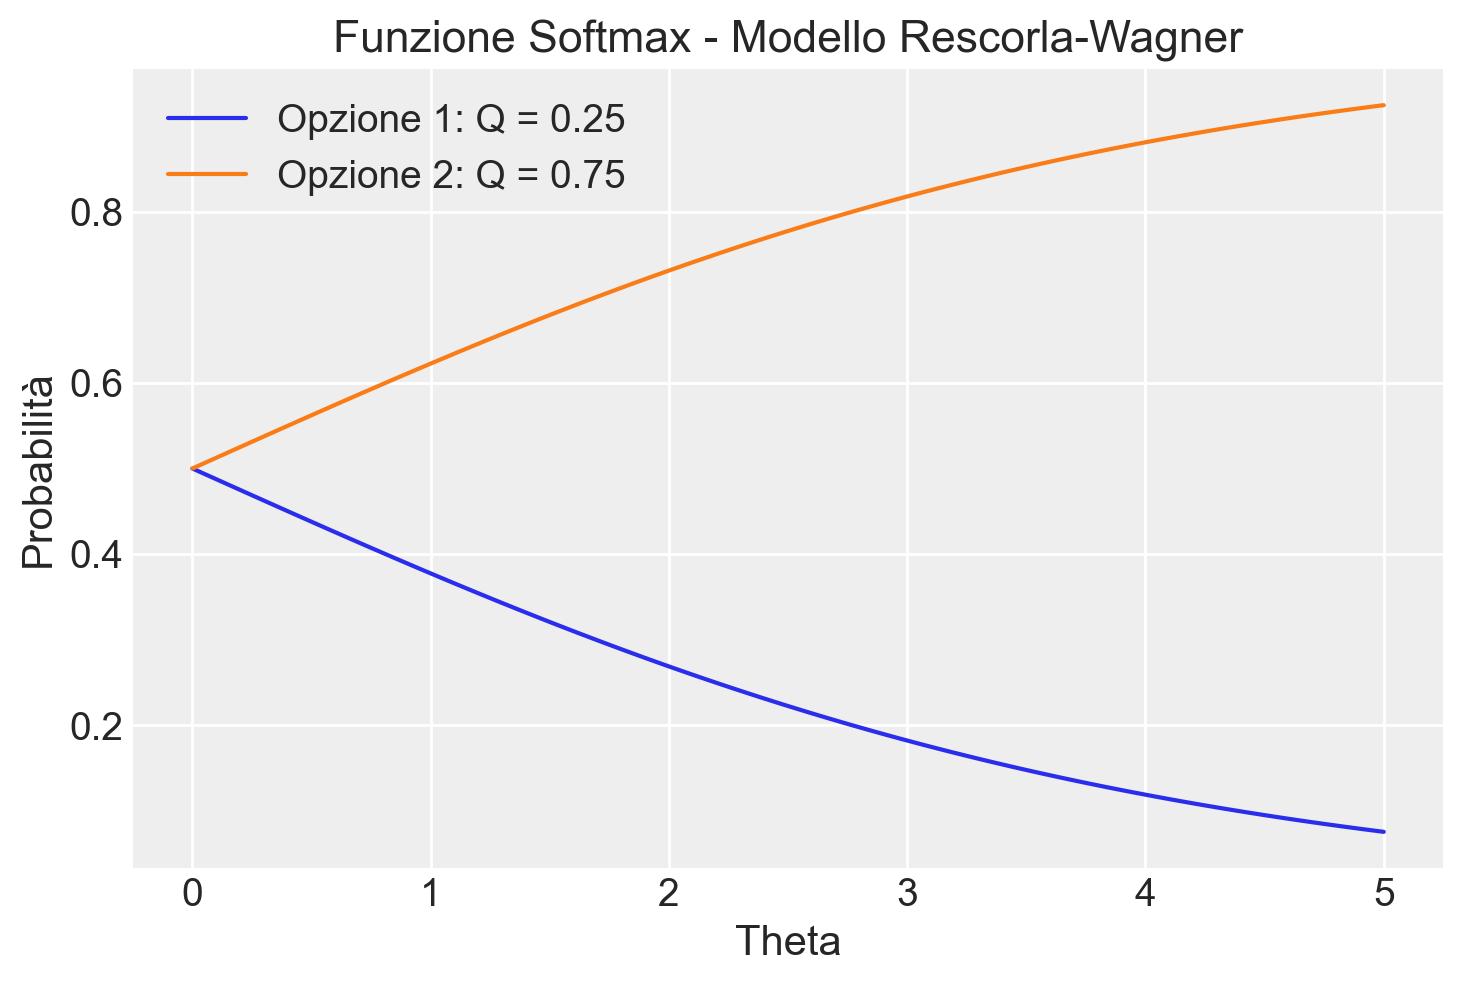

In [9]:
Q = np.array([0.25, 0.75])
theta_values = np.linspace(0, 5, 100)

probabilities_list = []
for theta in theta_values:
    probabilities = softmax(Q, theta)
    probabilities_list.append(probabilities)

probabilities_array = np.array(probabilities_list).T

option_labels = ['Opzione 1: Q = 0.25', 'Opzione 2: Q = 0.75']

plt.figure()
for i in range(len(option_labels)):
    plt.plot(theta_values, probabilities_array[i], label=option_labels[i])
plt.xlabel('Theta')
plt.ylabel('Probabilità')
plt.title('Funzione Softmax - Modello Rescorla-Wagner')
plt.legend()
plt.grid(True)
plt.show()

Il grafico risultante mostra come le probabilità di scelta cambiano al variare del parametro $\theta$. Quando $\theta$ è vicino a zero, la scelta è quasi casuale. Quando $\theta$ è molto grande, la scelta è quasi sempre l'opzione con il valore più alto.

## Simulazione del Modello di Rescorla-Wagner

Combiniamo la regola di apprendimento e la regola decisionale per simulare il comportamento del partecipante:

In [10]:
def simulate_RescorlaWagner(params, T, mu, noisy_choice=True):

    alpha, theta = params
    
    # Un array di zeri di lunghezza T
    c = np.zeros((T), dtype=int)
    r = np.zeros((T), dtype=int)

    # Un array multidimensionale di zeri di dimensione 2xT
    Q_stored = np.zeros((2, T), dtype=float)
    
    # Inizializza Q per t == 0
    Q = [0.5, 0.5]

    for t in range(T):

        # Salva i valori Q per Q_{t+1}
        Q_stored[:, t] = Q

        # Calcola le probabilità di scelta
        p0 = np.exp(theta*Q[0]) / (np.exp(theta*Q[0]) + np.exp(theta*Q[1]))
        p1 = 1 - p0
        
        # Se noisy_choice è vero, viene simulato un comportamento di scelta rumoroso in 
        # cui l'opzione 0 è scelta con probabilità p0, mentre l'opzione 1 è scelta con 
        # probabilità 1-p0.
        if noisy_choice:
            if np.random.random_sample(1) < p0:
                c[t] = 0
            else:
                c[t] = 1
        else:  # la scelta viene effettuata senza rumore
            c[t] = np.argmax([p0, p1])

        # Genera la ricompensa sulla base delle probabilità di ricompensa
        r[t] = np.random.rand() < mu[c[t]]

        # Aggiorna le aspettative di valore
        delta = r[t] - Q[c[t]]
        Q[c[t]] = Q[c[t]] + alpha * delta

    return c, r, Q_stored


Simuliamo `T` = 100 prove utilizzando il modello generativo dei dati definito in precedenza.

In [11]:
T = 100
K = 2
mu = [0.2, 0.8]

In [12]:
c, r, Q = simulate_RescorlaWagner([.1, 2.5], T=T, mu=mu)

Rappresentiamo graficamente i risultati ottenuti dalla simulazione.

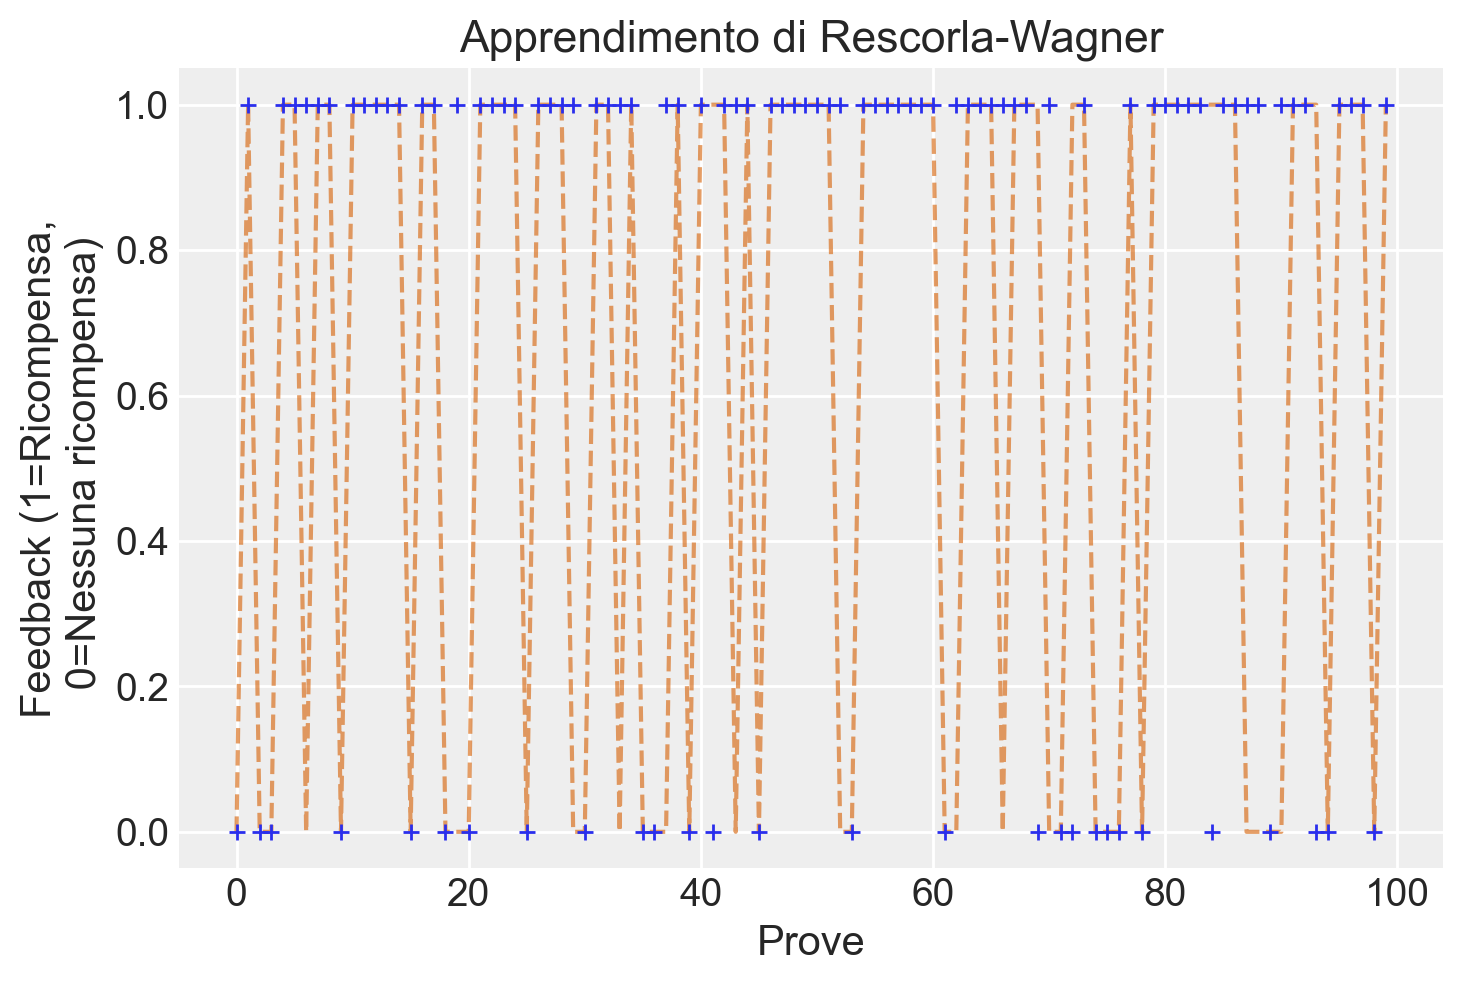

In [13]:
plt.plot(range(T), r, 'r--', alpha=.6)
plt.plot(range(T), c, '+', label='scelta')
plt.xlabel('Prove')
plt.ylabel('Feedback (1=Ricompensa,\n 0=Nessuna ricompensa)')
plt.title(f'Apprendimento di Rescorla-Wagner')
plt.show()


Come possiamo osservare, le scelte per la slot machine che produce meno ricompense diventano meno frequenti nel corso delle prove.

Il diagramma seguente illustra l'aggiornamento del valore $Q$, mostrando come l'aspettativa di ricompensa delle due slot machine venga aggiornata in base all'errore di predizione nel corso delle prove. 

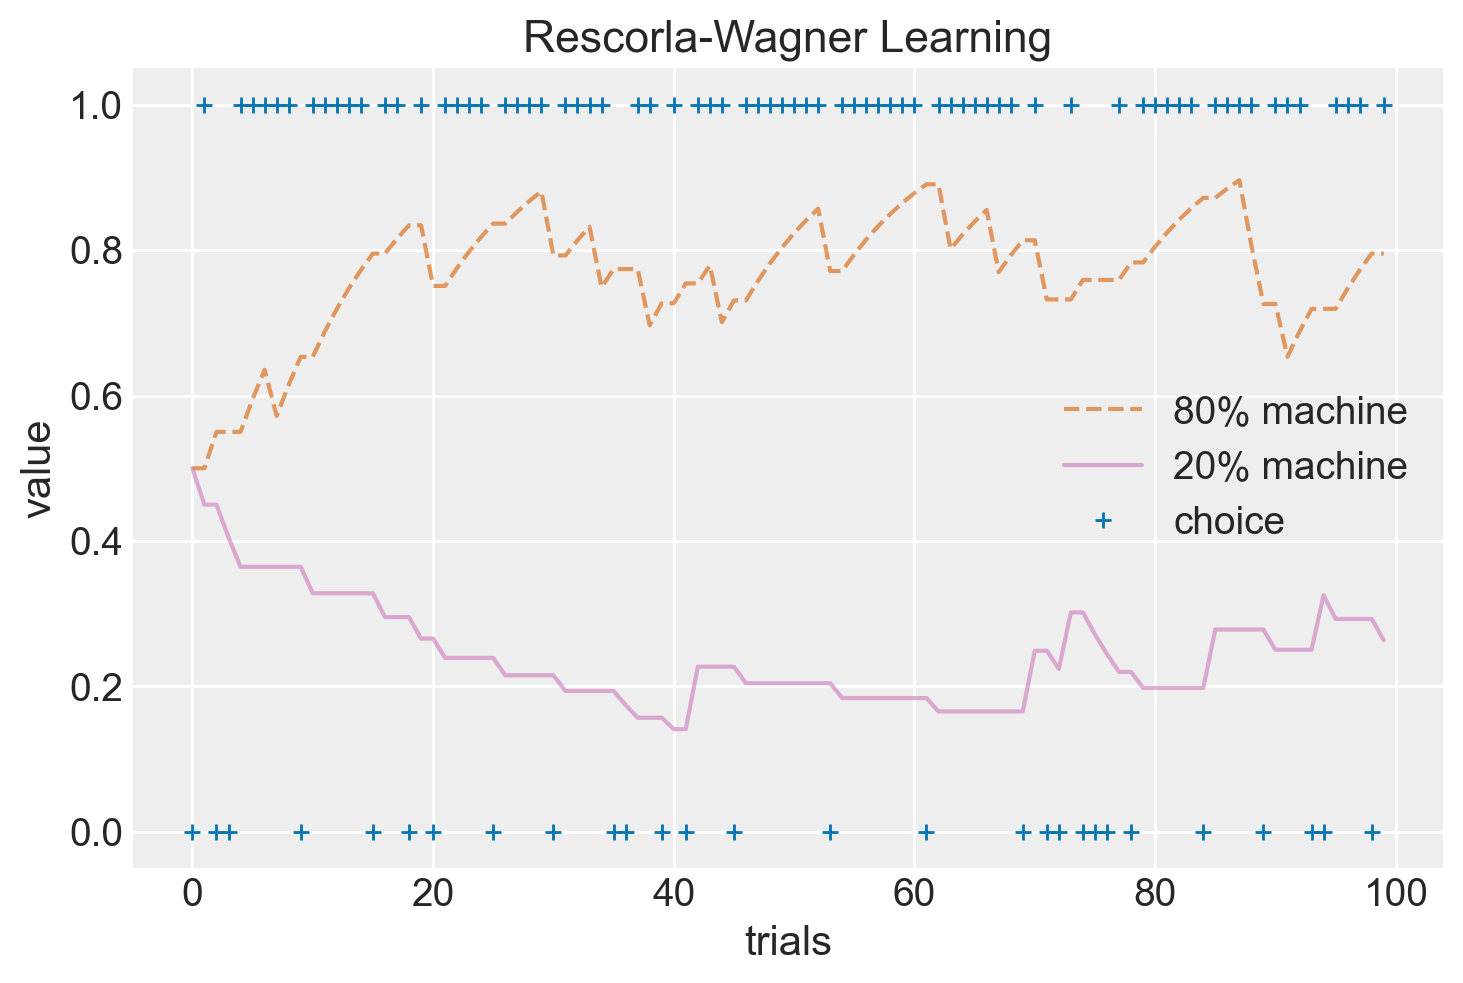

In [14]:
plt.plot(range(T), Q[1, :], "r--", alpha=0.6, label="80% machine")
plt.plot(range(T), Q[0, :], 'm-', alpha=.6, label='20% machine')
plt.plot(range(T), c, 'b+', label='choice')
plt.xlabel('trials')
plt.ylabel('value')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()

Si noti come nel corso delle prove i valori delle slot macchine convergano lentamente verso le probabilità di ricompensa (20% e 80%).

In sintesi, il modello di Rescorla-Wagner ci permette di simulare come le persone apprendono e prendono decisioni basate su ricompense. Utilizzando la regola di apprendimento ($\delta$-rule) e la regola decisionale softmax, possiamo vedere come le aspettative di valore e le scelte cambiano nel tempo in risposta alle ricompense ottenute.

## Adattamento del Modello

Dopo aver compreso il funzionamento del modello di Rescorla-Wagner, il passo successivo consiste nello stimare i parametri del modello a partire dai dati osservati. Questo processo è cruciale nella modellazione computazionale poiché ci permette di determinare quali valori dei parametri descrivono meglio il comportamento osservato. Esistono diversi metodi per stimare i parametri. La sezione @sec-rescorla-wagner-ml mostra come implementare l'approccio della *Massima Verosimiglianza*. Qui illustreremo la stima dei parametri del modello Rescorla-Wagner utilizzando un metodo bayesiano, attraverso l'uso di Stan. Procediamo quindi a compilare il modello e a stampare il codice Stan.

In [15]:
stan_file = os.path.join(project_directory, "stan", "rescorla_wagner.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=1> nTrials; // numero di tentativi
  array[nTrials] int<lower=1, upper=2> choice; // scelte effettuate (1 o 2)
  array[nTrials] real<lower=0, upper=1> reward; // ricompense ricevute (0 o 1)
}
transformed data {
  vector[2] initV; // valori iniziali per V
  initV = rep_vector(0.5, 2); // inizializzati a 0.5
}
parameters {
  real<lower=0, upper=1> alpha; // tasso di apprendimento
  real<lower=0> theta; // temperatura
}
model {
  vector[2] v; // valori attesi
  real delta; // errore di previsione
  
  // Priori
  alpha ~ beta(1, 1); // prior uniforme su [0, 1]
  theta ~ normal(0, 10); // prior normale con media 0 e deviazione standard 10
  
  v = initV;
  
  for (t in 1 : nTrials) {
    // Calcolo delle probabilità di scelta usando la funzione softmax con limitazione
    vector[2] logits;
    logits = theta * v;
    logits = fmin(logits, 20); // Limita i valori massimi per evitare overflow
    logits = fmax(logits, -20); // Limita i valori minimi per evitare underflow
 

### Sezione `data`

Questa sezione definisce i dati che vengono forniti al modello:

- `nTrials`: Il numero totale di tentativi o scelte effettuate dal partecipante.
- `choice`: Un array che contiene le scelte effettuate dal partecipante in ciascun tentativo (1 o 2).
- `reward`: Un array che contiene le ricompense ricevute per ciascun tentativo (0 o 1).

### Sezione `transformed data`

Questa sezione prepara alcuni dati iniziali trasformati per il modello. Qui `initV` è un vettore di lunghezza 2 che rappresenta i valori iniziali delle aspettative di ricompensa per le due opzioni, entrambi inizializzati a 0.5.

### Sezione `parameters`

Questa sezione definisce i parametri del modello che Stan cercherà di stimare:

- `alpha`: Il tasso di apprendimento, che determina quanto rapidamente il partecipante aggiorna le proprie aspettative. Questo valore è compreso tra 0 e 1.
- `theta`: La temperatura, che controlla il livello di esplorazione (quanto spesso il partecipante sceglie l'opzione con il valore atteso più alto rispetto a esplorare altre opzioni). Questo valore è positivo.

### Sezione `model`

La sezione `model` del codice Stan è il cuore del modello, dove avviene il processo di stima e aggiornamento dei valori attesi in base ai dati osservati. Vediamo passo passo come funziona.

1. Inizializzazione.

   - Partiamo con valori attesi uguali per entrambe le opzioni (`v = [0.5, 0.5]`).
   - Scegliamo valori casuali iniziali per `alpha` e `theta`.

2. Per ogni tentativo dell'esperimento:

   a) Calcolo delle probabilità di scelta:

   ```stan
   logits = theta * v;
   logits = fmin(logits, 20);
   logits = fmax(logits, -20);
   ```

   - Moltiplichiamo i valori attesi per la temperatura.
   - Limitiamo i risultati tra -20 e 20 per evitare problemi numerici.

   *Esempio:*

   Se `v = [0.3, 0.7]` e `theta = 2`:

   1. `logits = 2 * [0.3, 0.7] = [0.6, 1.4]`
   2. Nessun cambiamento dopo `fmin` e `fmax` perché i valori sono già tra -20 e 20.

   b) Modellazione della scelta:

   ```stan
   choice[t] ~ categorical_logit(logits);
   ```

   - Usiamo i `logits` per calcolare le probabilità di scelta.
   - La funzione `softmax` converte i `logits` in probabilità.

   *Esempio (continuazione):*

   - `softmax([0.6, 1.4]) ≈ [0.38, 0.62]`
   - C'è il 38% di probabilità di scegliere la prima opzione e il 62% per la seconda.

   c) Calcolo dell'errore di previsione:

   ```stan
   delta = reward[t] - v[choice[t]];
   ```

   - Confrontiamo la ricompensa ricevuta con quanto ci aspettavamo.
   - Se positivo, siamo stati piacevolmente sorpresi; se negativo, delusi.

   *Esempio:*

   Se scegliamo la seconda opzione e riceviamo una ricompensa di 1:

   - `delta = 1 - 0.7 = 0.3`

   Siamo stati leggermente sorpresi in positivo.

   d) Aggiornamento dei valori attesi:

   ```stan
   v[choice[t]] = v[choice[t]] + alpha * delta;
   ```

   - Aggiorniamo la nostra aspettativa per l'opzione scelta.
   - `alpha` determina quanto peso diamo alla nuova esperienza.

   *Esempio (continuazione):*

   Se `alpha = 0.2`:

   - Nuovo valore per la seconda opzione: `0.7 + 0.2 * 0.3 = 0.76`

   La nostra aspettativa per la seconda opzione è leggermente aumentata.

3. Ripetizione.

- Ripetiamo i passaggi 2a-2d per ogni tentativo dell'esperimento.
- Ad ogni iterazione, affiniamo le nostre stime di `alpha` e `theta`.

### Inferenza

Considereremo qui i dati di un singolo partecipante che esegue 300 prove. Definiamo i parametri della simulazione:

In [16]:
params = [0.1, 2.5]  # alpha, theta
T = 300  # numero di tentativi
mu = [0.2, 0.8]  # probabilità di ricompensa per le due opzioni

Simuliamo i dati:

In [17]:
choices, rewards, Q_stored = simulate_RescorlaWagner(params, T, mu)

Prepariamo i dati per Stan. Si noti che abbiamo sommato 1 a `choices` per adattarsi agli indici di Stan che partono da 1.

In [18]:
c = choices + 1

stan_data = {
    'nTrials': T,
    'choice': c.tolist(),
    'reward': rewards.tolist()
}
print(stan_data)

{'nTrials': 300, 'choice': [2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1], 'reward': [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 

Eseguiamo il campionamento:

In [19]:
trace = model.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

21:15:55 - cmdstanpy - INFO - CmdStan start processing
21:15:55 - cmdstanpy - INFO - Chain [1] start processing
21:15:55 - cmdstanpy - INFO - Chain [2] start processing
21:15:55 - cmdstanpy - INFO - Chain [3] start processing
21:15:55 - cmdstanpy - INFO - Chain [4] start processing
21:15:59 - cmdstanpy - INFO - Chain [3] done processing
21:15:59 - cmdstanpy - INFO - Chain [2] done processing
21:15:59 - cmdstanpy - INFO - Chain [1] done processing
21:15:59 - cmdstanpy - INFO - Chain [4] done processing


Esaminiamo le distribuzioni a posteriori dei due parametri oggetto dell'inferenza insieme alle loro tracce (cioè i vettori dei campioni dei parametri $\alpha$ e $\theta$ prodotti dalla procedura di campionamento MCMC) mediante un *trace plot* .

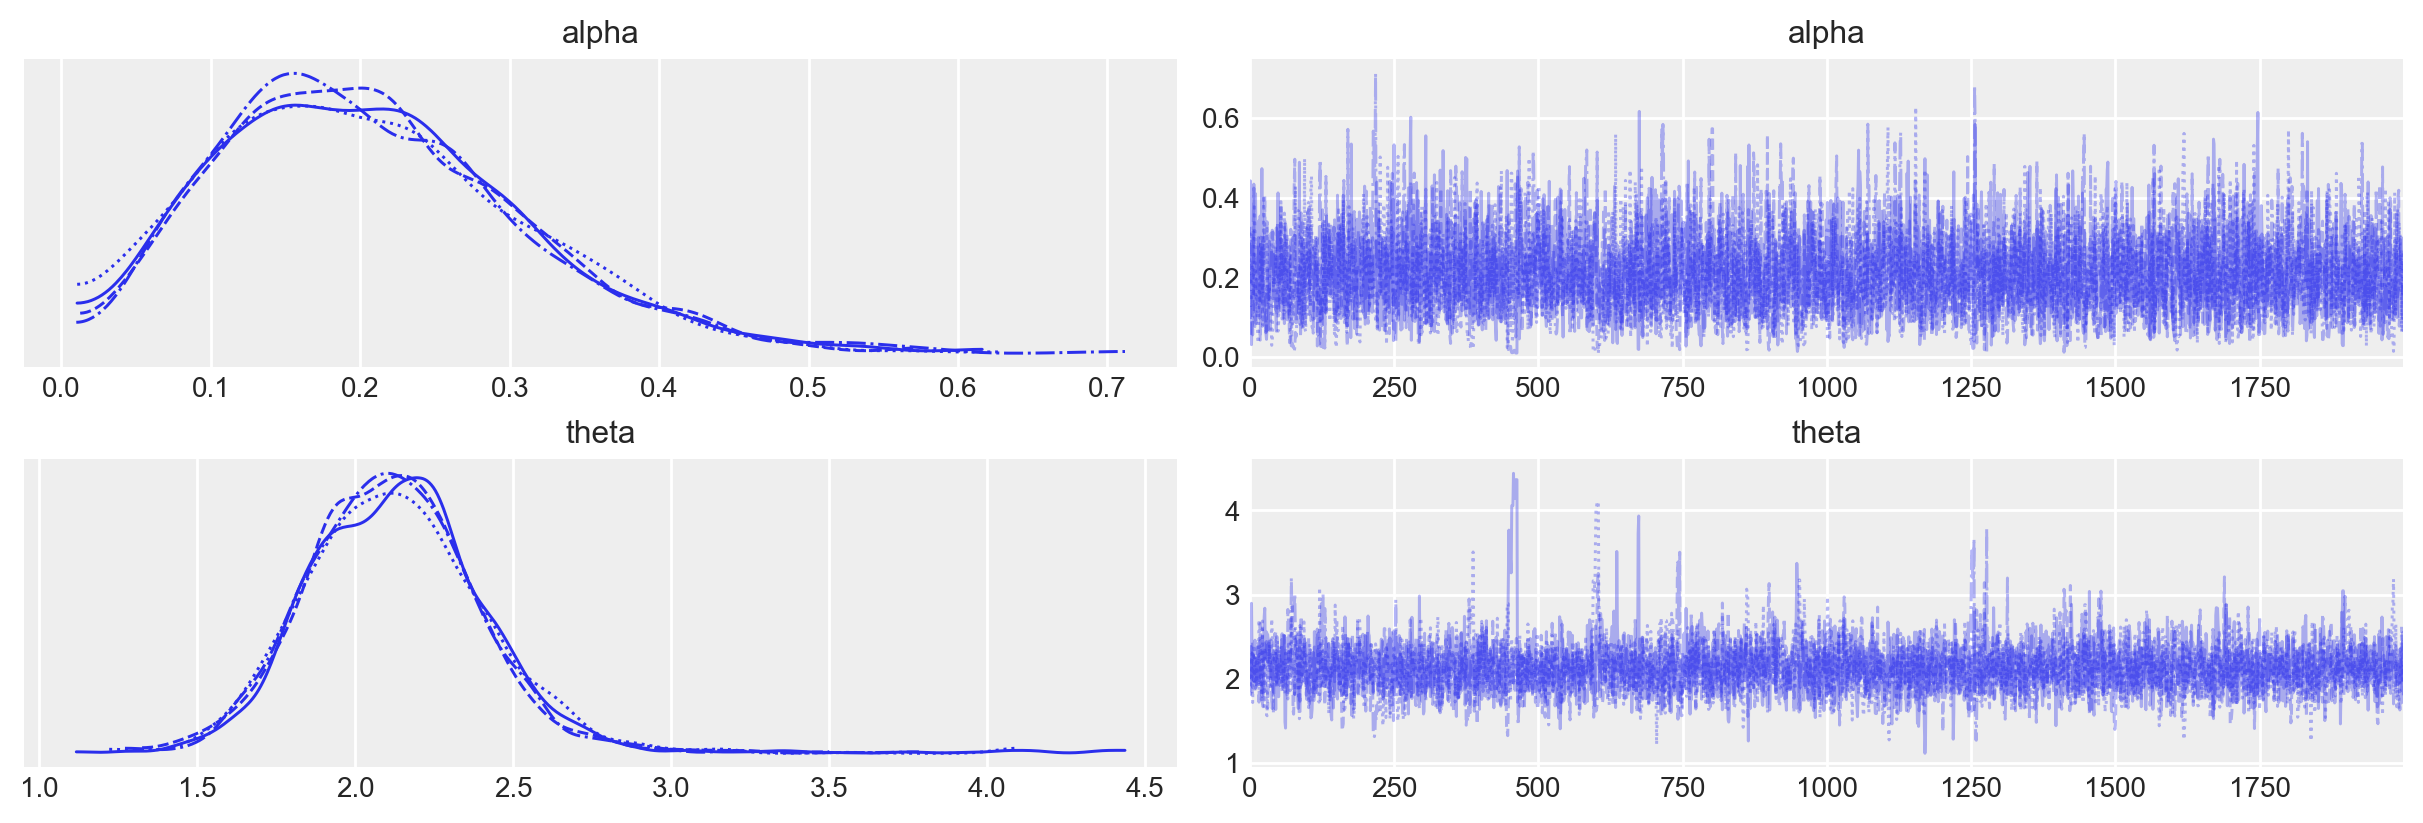

In [23]:
_ = az.plot_trace(trace)

### Interpretazione delle Stime dei Parametri

Utilizzando `az.summary(trace, hdi_prob=0.94, round_to=2)`, otteniamo un riassunto delle stime dei parametri del modello, che include la media, la deviazione standard, gli intervalli di credibilità (HDI) e altre statistiche diagnostiche:

In [25]:
az.summary(trace, hdi_prob=0.94, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.13,0.08,0.02,0.27,0.00,0.00,1973.89,1757.85,1.0
theta,2.70,0.41,2.01,3.46,0.01,0.01,2095.86,1581.69,1.0


Con 300 prove, le stime dei parametri fornite dal modello sono adeguate:

- L'intervallo di credibilità al 94% (hdi_3% - hdi_97%) include il valore simulato del parametro. Questo significa che le stime del modello sono coerenti con i parametri originali usati nella simulazione.
- La deviazione standard della stima a posteriori è relativamente piccola, indicando che le stime sono precise.
- I valori di `r_hat` sono vicini a 1, indicando che le catene di campionamento sono ben mescolate e hanno ottenuto la convergenza.

Questi risultati suggeriscono che il modello di apprendimento di Rescorla-Wagner ha stimato correttamente i parametri $\alpha$ e $\theta$ dai dati simulati.

## Apprendimento Probabilistico e Reversal Learning

Un paradigma sperimentale particolarmente interessante per indagare i meccanismi dell'apprendimento umano è il *Probabilistic Reversal Learning* [@caudek2020cognitive; @caudek2021susceptibility]. In questo compito, le associazioni tra stimoli e outcomes vengono invertite a metà della procedura sperimentale. Ad esempio, se inizialmente lo stimolo A era associato a una ricompensa, in seguito questa associazione può essere invertita, rendendo lo stimolo A svantaggioso.

L'apprendimento per rinforzo offre un solido quadro teorico per comprendere come gli individui si adattano a tali cambiamenti. Modelli computazionali come quello di Rescorla-Wagner possono essere impiegati per simulare questo tipo di apprendimento e per studiare i processi cognitivi sottostanti.

## Incertezza Attesa vs. Incertezza Non Attesa

Nel contesto dell'apprendimento per rinforzo e dei modelli come quello di Rescorla-Wagner, è fondamentale distinguere tra **incertezza attesa** e **incertezza non attesa**, poiché influenzano in modo diverso il processo di apprendimento.

1. **Incertezza Attesa**: L'incertezza attesa si riferisce alla variabilità che esiste a causa della natura probabilistica delle ricompense, anche quando le condizioni dell'ambiente rimangono invariate. Ad esempio, se un agente sa che un'azione A ha una probabilità dell'80% di fornire una ricompensa positiva e del 20% di fornire una ricompensa negativa, l'incertezza attesa deriva dal fatto che, nonostante la conoscenza delle probabilità, l'esito di ogni singola azione rimane imprevedibile. In altre parole, anche se l'agente sa che un'azione è generalmente buona, non può prevedere con certezza il risultato di ogni tentativo. Questo tipo di incertezza è considerato "irreducibile" perché non può essere eliminato semplicemente con l'accumulo di esperienze.

2. **Incertezza Non Attesa**: L'incertezza non attesa, invece, si riferisce alla variabilità che emerge quando le condizioni o le regole dell'ambiente cambiano in modo imprevisto. Ad esempio, se un'azione A che di solito porta a una ricompensa positiva improvvisamente inizia a portare a una ricompensa negativa, l'incertezza non attesa deriva da questo cambiamento inatteso. Questo tipo di incertezza richiede che l'agente aggiorni rapidamente le sue aspettative e strategie, poiché le informazioni precedenti non sono più valide. L'incertezza non attesa è quindi legata alla "volatilità" dell'ambiente e alla necessità di adattarsi ai cambiamenti.

In sintesi, l'incertezza attesa riguarda la variabilità nelle ricompense che è già nota e considerata nel processo decisionale dell'agente, mentre l'incertezza non attesa implica un cambiamento nelle regole dell'ambiente che richiede un adattamento rapido. Comprendere la differenza tra questi due tipi di incertezza è cruciale per modellare accuratamente il comportamento di apprendimento e prendere decisioni ottimali in ambienti dinamici.

## Anomalie dell'apprendimento

L'uso dei modelli di apprendimento per rinforzo, come il modello di Rescorla-Wagner, ha importanti implicazioni per comprendere le anomalie dell'apprendimento nelle patologie psicologiche, come l'ansia e la depressione [@pulcu2019misestimation]. Questi modelli aiutano a spiegare come le persone con disturbi affettivi possano avere difficoltà a stimare correttamente l'incertezza, sia attesa che non attesa, riguardo agli esiti delle loro azioni. 

Ad esempio, una sovrastima dell'incertezza attesa o una sottostima dell'incertezza non attesa può rendere un individuo meno reattivo agli eventi recenti e più lento nell'adattarsi a cambiamenti importanti, specialmente in ambienti dinamici e poco rumorosi. Al contrario, una sottostima dell'incertezza attesa o una sovrastima dell'incertezza non attesa può portare a una maggiore influenza degli eventi recenti e a credenze instabili, specialmente in ambienti stabili ma rumorosi. Questa errata stima dell'incertezza può ridurre la capacità di un individuo di tracciare accuratamente lo stato degli ambienti dinamici e, di conseguenza, scegliere le azioni più adatte per ottenere risultati positivi o evitare quelli negativi. 

Inoltre, la tendenza a sopravvalutare l'incertezza non attesa degli esiti negativi rispetto a quelli positivi può portare a un'influenza maggiore degli eventi negativi, un profilo cognitivo tipico dell'ansia e della depressione. Studi recenti suggeriscono che i bias nella stima dell'incertezza potrebbero fornire un collegamento meccanicistico tra gli aspetti cognitivi interni della depressione e dell'ansia e i fattori di rischio esterni, come l'esposizione a esperienze avverse. Pertanto, l'integrazione di modelli di apprendimento per rinforzo come il Rescorla-Wagner nelle ricerche cliniche può offrire nuove prospettive per comprendere e trattare questi disturbi [@browning2015anxious].

## Commenti e considerazioni finali 

In precedenza abbiamo esaminato il modello di regressione. Sebbene il modello di regressione sia estremamente popolare in psicologia e nelle scienze sociali, presenta dei limiti sostanziali. È utile per descrivere le associazioni tra variabili, ma non è adatto per scoprire nessi causali, che rappresentano l'obiettivo principale delle teorie scientifiche. Come afferma Richard McElreath:

> Le persone una volta facevano teoria. Ora fanno solo regressioni.

Trovare associazioni nei dati osservazionali non è un buon metodo per costruire teorie. Abbiamo bisogno di una motivazione per esaminare determinate variabili, poiché le associazioni tra variabili non sono rare, ma raramente ci informano sulle relazioni causali. 

Un approccio preferibile è utilizzare una teoria formale per sviluppare aspettative sui dati osservati, misurare le variabili rilevanti e utilizzare modelli statistici specifici per testare la teoria.

L'apprendimento per rinforzo offre un potente framework per studiare come gli organismi apprendono dall'interazione con l'ambiente. Modelli come quello di Rescorla-Wagner e algoritmi come UCB e Thompson Sampling forniscono strumenti utili per comprendere i processi cognitivi sottostanti l'apprendimento associativo e per sviluppare agenti intelligenti. Questi modelli hanno raggiunto un notevole successo, fornendo spiegazioni computazionali sia per fenomeni di apprendimento di base che complessi [@eckstein2020computational; @frank2012mechanisms]. 

Tuttavia, è importante riconoscere alcune limitazioni di questi modelli di apprendimento per rinforzo. La letteratura scientifica ha infatti accumulato una serie di osservazioni che questi modelli faticano a spiegare adeguatamente [@ecksteinhybrid]. In primo luogo, eventi singoli del passato possono influenzare il comportamento in modo sproporzionato [@duncan2016memory; @schulz2019algorithmic; @bornstein2017reinstated]. Questo suggerisce che la memoria rilevante per il compito contiene più che semplici statistiche riassuntive come i Q-values. In altre parole, le esperienze passate possono avere un impatto duraturo e significativo sulle decisioni future, anche se non riflesse nei valori medi appresi. In secondo luogo, il comportamento è spesso sensibile a statistiche globali del passato, come l'intervallo di ricompense ricevute o il raggruppamento delle opzioni di scelta [@palminteri2015contextual; @khaw2017normalized]. Questi aspetti non sono facilmente catturati dai modelli standard di apprendimento per rinforzo, che tendono a concentrarsi su valori specifici per ogni azione piuttosto che su pattern più ampi. Infine, i segnali neurali precedentemente ritenuti direttamente correlati ai Q-values hanno mostrato una marcata diversità che è in contrasto con le previsioni dei modelli standard di apprendimento per rinforzo [@yaple2019fractionating]. Questa variabilità suggerisce che i processi neurali sottostanti alle decisioni basate su ricompense sono più complessi di quanto inizialmente si pensasse.

Nell'insieme, questi risultati indicano che le rappresentazioni mnemoniche utilizzate da esseri umani e animali per prendere decisioni basate su ricompense vanno oltre le semplici statistiche riassuntive apprese in modo incrementale e associate a singole azioni. È probabile che queste decisioni si basino su una varietà di meccanismi di memoria interni aggiuntivi, che permettono una rappresentazione più ricca e sfumata delle esperienze passate e del contesto decisionale. Questa complessità sottolinea la necessità di sviluppare modelli più sofisticati che possano catturare la ricchezza dei processi decisionali osservati negli organismi biologici, integrando aspetti di memoria episodica, sensibilità al contesto e variabilità nei segnali neurali.

## Esercizi

::: {#exr-rescorla-wagner-1}

Implementa una funzione Python `softmax` che prende in input un array di valori attesi `Q` per ciascuna azione e un parametro di temperatura `theta`. La funzione deve restituire un array di probabilità che rappresenta la probabilità di selezione di ciascuna azione.

La formula della regola softmax è la seguente:

$$ p_i = \frac{e^{\theta Q_i}}{\sum_{j} e^{\theta Q_j}}, $$

dove $p_i$ è la probabilità di selezionare l'azione $i$, $Q_i$ è il valore atteso dell'azione $i$, 
$\theta$ è il parametro di temperatura che controlla il livello di esplorazione.

Utilizza:

```python
Q = np.array([0.25, 0.75])
theta_values = [0.1, 1, 2, 5]
```

Questo esercizio fornisce una comprensione pratica di come la regola softmax bilancia esplorazione e sfruttamento nei modelli di apprendimento per rinforzo.

:::

::: {#exr-rescorla-wagner-2}

L'obiettivo di questo esercizio è implementare il calcolo dell'errore di previsione nel modello di Rescorla-Wagner. Implementa una funzione Python `update_value(Q, R, alpha)` che prende in input il valore atteso attuale `Q`, la ricompensa ricevuta `R`, il tasso di apprendimento `alpha`, e restituisce il nuovo valore atteso aggiornato. La funzione deve anche restituire l'errore di previsione.

Il valore atteso $Q$ viene aggiornato secondo la seguente formula:

$$ \Delta Q = \alpha (R - Q), $$

dove $\Delta Q$ è la variazione del valore atteso, 
$\alpha$ è il tasso di apprendimento, 
$R$ è la ricompensa ricevuta, 
$Q$ è il valore atteso attuale.

Il nuovo valore atteso $Q'$ è dato da $Q' = Q + \Delta Q$.

Usa:

```python
Q = 0.5  # Valore atteso iniziale
R_values = [1, 0, 1, 1, 0]  # Sequenza di ricompense ricevute
alpha = 0.1  # Tasso di apprendimento
```

Questo esercizio fornisce una comprensione pratica di come il modello di Rescorla-Wagner utilizza l'errore di previsione per aggiornare le aspettative di ricompensa.
:::

::: {#exr-rescorla-wagner-3}

L'obiettivo di questo esercizio è comprendere e interpretare i parametri del modello di apprendimento di Rescorla-Wagner. Considera i seguenti scenari in cui un agente sta apprendendo a fare delle scelte basate sulle ricompense ricevute. Per ciascuno scenario, descrivi come il tasso di apprendimento (`alpha`) e il valore iniziale atteso (`Q_0`) potrebbero influenzare il comportamento dell'agente.

1. **Scenario 1: Apprendimento Rapido in un Ambiente Stabile** Un cane sta imparando a eseguire un nuovo trucco e riceve sempre una ricompensa (un bocconcino) ogni volta che esegue il trucco correttamente.
2. **Scenario 2: Apprendimento Lento in un Ambiente Stabile** Un bambino sta imparando a risolvere puzzle semplici. Ogni volta che completa un puzzle, riceve una stella adesiva come ricompensa.
3. **Scenario 3: Apprendimento in un Ambiente Variabile** Un giocatore di un videogioco sta cercando di capire quale arma è la migliore contro diversi nemici. Le ricompense (punteggi) per l'uso delle armi variano in modo imprevedibile.
4. **Scenario 4: Apprendimento con Informazioni Iniziali Parziali** Un ricercatore che ha una conoscenza preliminare su quale farmaco potrebbe funzionare meglio sta conducendo un esperimento per confermare la sua ipotesi.

:::

::: {#exr-rescorla-wagner-4}

L'obiettivo di questo esercizio è analizzare come il modello di Rescorla-Wagner può essere applicato in diversi contesti di apprendimento e come le variazioni nelle condizioni ambientali e nelle caratteristiche dell'agente possono influenzare l'efficacia dell'apprendimento.

Per ciascuno dei seguenti contesti di apprendimento, descrivi come l'errore di previsione e l'aggiornamento del valore atteso influenzerebbero il comportamento dell'agente. Discuti anche eventuali limitazioni del modello di Rescorla-Wagner nel catturare tutti gli aspetti del processo di apprendimento in quel contesto.

1. **Contesto 1: Addestramento di un Animale Domestico** Un cane viene addestrato a eseguire un comando specifico, come "seduto". Ogni volta che il cane esegue correttamente il comando, riceve una ricompensa.
2. **Contesto 2: Apprendimento Scolastico** Uno studente sta imparando una nuova materia a scuola. Riceve un feedback positivo o negativo (es. voti) in base alle sue prestazioni nei compiti e nelle verifiche.
3. **Contesto 3: Terapia Comportamentale** Un terapeuta utilizza tecniche di rinforzo per aiutare un paziente a superare una fobia. Il paziente riceve rinforzi positivi ogni volta che riesce ad affrontare la situazione temuta senza evitare.
4. **Contesto 4: Apprendimento nelle Organizzazioni** Un'azienda implementa un sistema di premi per i dipendenti che raggiungono determinati obiettivi di performance. I dipendenti ricevono bonus e riconoscimenti in base ai risultati raggiunti.

:::

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [26]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sun Aug 18 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
seaborn   : 0.13.2
matplotlib: 3.9.1
arviz     : 0.18.0

Watermark: 2.4.3

